In [1]:
import numpy as np
import pandas as pd
import glob
import os
import sys
import matplotlib.pyplot as plt
import torch
import matplotlib.gridspec as gridspec
from torch.utils.data import Dataset
from torch.utils.data import DataLoader


def plot_densities(filepath, density_file):
    x_range = slice(60, 188) 
    filename = os.path.basename(filepath)
    dose = np.load(filepath)

    density = np.load(density_file)
    max_index = np.unravel_index(dose.argmax(), dose.shape)

    fig = plt.figure(figsize=(12, 3))
    gs = gridspec.GridSpec(1, 4, width_ratios=[2, 2, 2, 0.2])  # 3 plots + 1 colorbar

    # ZY plane
    ax0 = plt.subplot(gs[0])
    ax0.imshow(density[:, :, max_index[2]], cmap='gray')
    ax0.imshow(dose[:, :,max_index[2]], cmap='inferno', alpha=0.5)
    ax0.set_xlabel('Y voxel number')
    ax0.set_ylabel('Z voxel number')


    # ZX plane
    ax1 = plt.subplot(gs[1])
    ax1.imshow(density[:, max_index[1], x_range], cmap='gray')
    ax1.imshow(dose[:, max_index[1], x_range], cmap='inferno', alpha=0.5)
    ax1.set_xlabel('X voxel number')
    ax1.set_ylabel('Z voxel number')

    # YX plane
    ax2 = plt.subplot(gs[2])
    ax2.imshow(density[max_index[0], :, x_range], cmap='gray')
    ax2.imshow(dose[max_index[0], :, x_range], cmap='inferno', alpha=0.5)
    ax2.set_xlabel('X voxel number')
    ax2.set_ylabel('Y voxel number')
    ax2.set_ylim(235,60)

    # Colorbar
    cax = plt.subplot(gs[3])
    cbar = plt.colorbar(ax2.get_images()[1], cax=cax)
    cbar.set_label('Dose [Gy]')

    plt.tight_layout()
    plt.show()



In [2]:
import SimpleITK as sitk

# xzy
datasets = {
    "Data1": {
        "voxel_dim": [0.707031*2, 0.707031*2, 1.25*2],
        "origin": [-181, -181, -229],
        "positions_x": [-110],
        "positions_y": [-50, -25, 0, 25, 50, 75],
        "positions_z": [-146.5, -121.5, -96.5, -71.5, -46.5],
        "voxel_center": [0,0,-71.5]
    },
    "Data2": {
        "voxel_dim": [0.759766*2, 0.759766*2, 1.25*2],
        "origin": [-194.5, -194.5, -271],
        "positions_x": [-110],
        "positions_y": [-25, 0, 25, 50, 75],
        "positions_z": [-171.5, -146.5, -121.5, -96.5, -71.5],
        "voxel_center": [0,0,-72.25]
    },
    "Data4": {
        "voxel_dim": [0.666016*2, 0.666016*2, 1.25*2],
        "origin": [-170.5,-170.5, -188.75],
        "positions_x": [-110],
        "positions_y": [-50, -25, 0, 25, 50, 75],
        "positions_z": [-71.5, -46.5, -21.5, 3.5],
        "voxel_center": [0,0,-32.5]
    },
    "Data5": {
        "voxel_dim": [0.689453*2, 0.689453*2, 1.25*2],
        "origin": [-176.5, -176.5, -208.25],
        "positions_x": [-110],
        "positions_y": [-50, -25, 0, 25, 50, 75],
        "positions_z": [-96.5, -71.5, -46.5, -21.5],
        "voxel_center": [0,0,-44.5]
    },
    "Data7": {
        "voxel_dim": [0.683594*2, 0.683594*2, 1.25*2],
        "origin": [-175, -175, -199.25],
        "positions_x": [-110],
        "positions_y": [-25, 0, 25, 50, 75],
        "positions_z": [-96.5, -71.5, -46.5, -21.5],
        "voxel_center": [0,0,-29.25]
    }
}



def set_sitk_image(array, dataset):
    # Convert numpy array to SimpleITK image
    sitk_image = sitk.GetImageFromArray(array)  
    # Set the spacing for data
    spacing = datasets[dataset]["voxel_dim"]
    sitk_image.SetSpacing(spacing) #xyz
    origin = datasets[dataset]["origin"]
    sitk_image.SetOrigin(origin)
    #print(sitk_image.GetSpacing(),sitk_image.GetOrigin() )
    return sitk_image

    
def resample_image(input_image, new_spacing, new_origin):
    size = input_image.GetSize()
    spacing = input_image.GetSpacing()
    new_size = [int(size[d] * spacing[d] / new_spacing[d]) for d in range(3)]
    resampler = sitk.ResampleImageFilter()
    resampler.SetSize(new_size)
    resampler.SetOutputSpacing(new_spacing)
    resampler.SetOutputOrigin(new_origin)
    resampler.SetOutputDirection(input_image.GetDirection())
    resampler.SetInterpolator(sitk.sitkNearestNeighbor) # preserve the original data values without smoothing
    
    resampled_image = resampler.Execute(input_image)
    return resampled_image

def extract_from_filename(filename, param):
    """Extracts energy value from the given filename."""
    parts = filename.split('_')
    if param == 'y':
        return float(parts[2][:-2])
    if param == 'z':
        return float(parts[3][:-6])
    if param == 'energy':
        return parts[1]
    else:
        return None

# function to extract ROI and convert to numpy
def extract_roi_array(image, roi_size, center_physical):
    source_index = image.TransformPhysicalPointToIndex(center_physical)
    print('source index y,z',source_index[1], source_index[2] )
    start_index = [int(source_index[0]-roi_size[0]*0.5), int(source_index[1]-roi_size[1]*0.5), int(source_index[2]-roi_size[2]*0.5)]
    print('start_index' , start_index)
    roi = sitk.RegionOfInterest(image, roi_size, start_index)
    return sitk.GetArrayFromImage(roi) 


In [3]:
import torch
import matplotlib.pyplot as plt
from matplotlib import gridspec
def plot_roi(roi_array,density):

    # Define center of the volume
    i =  int(roi_array.shape[0]/2)-1

    data_sample = roi_array

    print('Y direction')
    print('voxel number ',i)
    #density_sample = density_batch[i, 0]
    #data_name_sample = data_name_batch[i]
    # Define the figure and the grid
    fig = plt.figure(figsize=(15, 3))
    gs = gridspec.GridSpec(1, 3, width_ratios=[1, 2, 0.2])  # 3 plots + 1 colorbar
    max_index = np.unravel_index(data_sample.argmax(), data_sample.shape)
        
    # ZY plane
    ax0 = plt.subplot(gs[0])
    ax0.imshow(density[:, :, max_index[2]], cmap='gray')
    ax0.imshow(data_sample[:, :,max_index[2]], cmap='inferno', alpha=0.7)
    ax0.set_title("ZY Plane")
    ax0.set_xlabel('Z voxel number')
    ax0.set_ylabel('Y voxel number')

    # ZX plane
    ax1 = plt.subplot(gs[1])
    ax1.imshow(density[:, i, :], cmap='gray')
    img_data = ax1.imshow(data_sample[:, i, :], cmap='inferno', alpha=0.7)
    ax1.set_xlabel('X voxel number')
    ax1.set_ylabel('Z voxel number')

    # Colorbar
    cax = plt.subplot(gs[2])
    cbar = plt.colorbar(img_data, cax=cax)
    cbar.set_label('Dose [Gy')

    plt.tight_layout()
    plt.show()

    print('Z direction')

    print('voxel number ',i)
    #density_sample = density_batch[i, 0]
    #data_name_sample = data_name_batch[i]
    # Define the figure and the grid
    fig = plt.figure(figsize=(15, 3))
    gs = gridspec.GridSpec(1, 3, width_ratios=[1, 2, 0.2])  # 3 plots + 1 colorbar
    max_index = np.unravel_index(data_sample.argmax(), data_sample.shape)
        
    # ZY plane
    ax0 = plt.subplot(gs[0])
    ax0.imshow(density[:, :, max_index[2]], cmap='gray')
    ax0.imshow(data_sample[:, :,max_index[2]], cmap='inferno', alpha=0.7)
    ax0.set_title("ZY Plane")
    ax0.set_xlabel('Z voxel number')
    ax0.set_ylabel('Y voxel number')

    # YX plane
    ax2 = plt.subplot(gs[1])
    ax2.imshow(density[i, :, :], cmap='gray')
    img_data = ax2.imshow(data_sample[i, :, :], cmap='inferno', alpha=0.7)
    ax2.set_xlabel('X voxel number')
    ax2.set_ylabel('Y voxel number')

    # Colorbar
    cax = plt.subplot(gs[2])
    cbar = plt.colorbar(img_data, cax=cax)
    cbar.set_label('Dose [Gy]')

    plt.tight_layout()
    plt.show()

In [4]:
def resample_density(density_path):
    '''Take input as density file path and convert to SimpleITK image and resample to physical space of Data1
return resampled SimpleITK image'''

    filename = os.path.basename(density_path) # Example "Data2.npy"
    dataset = filename.split('.')[0]    #Data2
    target_spacing = datasets["Data1"]["voxel_dim"]
    target_origin = datasets["Data1"]["origin"]
    
    #print(dataset)
    # Load data from .npy
    array = np.load(density_path)
    #print(array.shape)
    # Convert numpy array to SimpleITK image and set parameters
    image = set_sitk_image(array, dataset)

    if dataset != 'Data1':
        # Resample the image
        resampled = resample_image(image, target_spacing, target_origin)
    if dataset == 'Data1':
        resampled = image
    return resampled


def get_density_roi(filepath):
    roi_size = (128,16,16) #xyz  
    filename = os.path.basename(filepath) # Example "Data1_1500MeV_0Mm_-121.5Mm.npy"
    dataset = filename.split('_')[0] # Example Data1, Data2
    density_folder =  "/scratch/tappay01/densities/"
    density_path = os.path.join(density_folder,  dataset +'.npy')
    resampled = resample_density(density_path)
    # Extract ROI    
    # y z source position extract from file name
    # source at x postion = -110, but use -5 to crop from this point as center, which is index 124. 
    # We want to crop X range size 128 from index 60 to 188 to cover the head.
    source_physical = [-5, extract_from_filename(filename,'y'), extract_from_filename(filename,'z')]
    density_roi_array = extract_roi_array(resampled, roi_size, source_physical)

    return density_roi_array

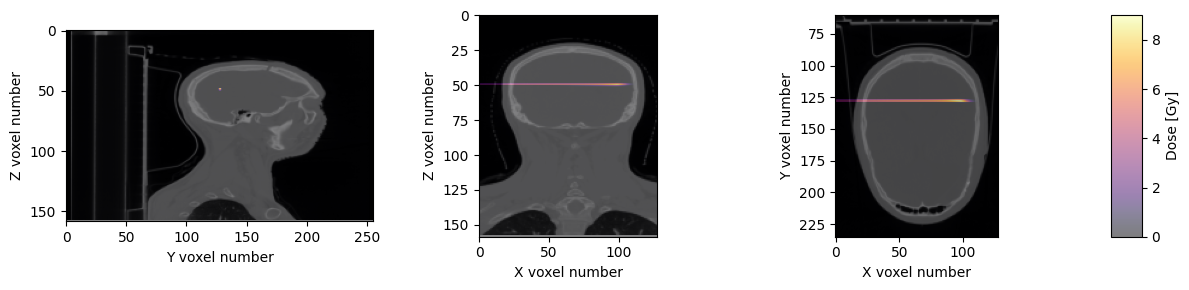

In [5]:
density2_file = "/scratch/tappay01/densities/Data2.npy"
file_data2 = "/scratch/tappay01/data/data2/Data2_1500MeV_0Mm_-146.5Mm.npy"
plot_densities(file_data2, density2_file)

Check some file of resampled data and plot with its density.


array shape (16, 16, 128)
source index y,z 128 33
start_index [60, 120, 25]
Y direction
voxel number  7


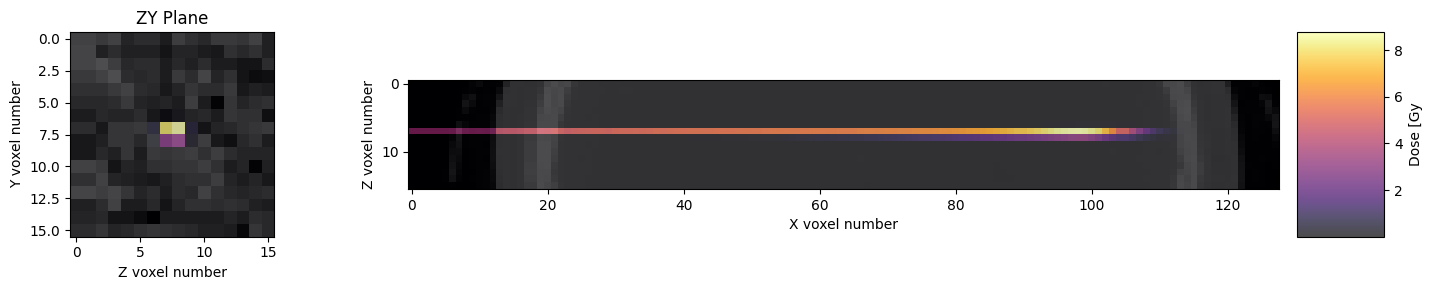

Z direction
voxel number  7


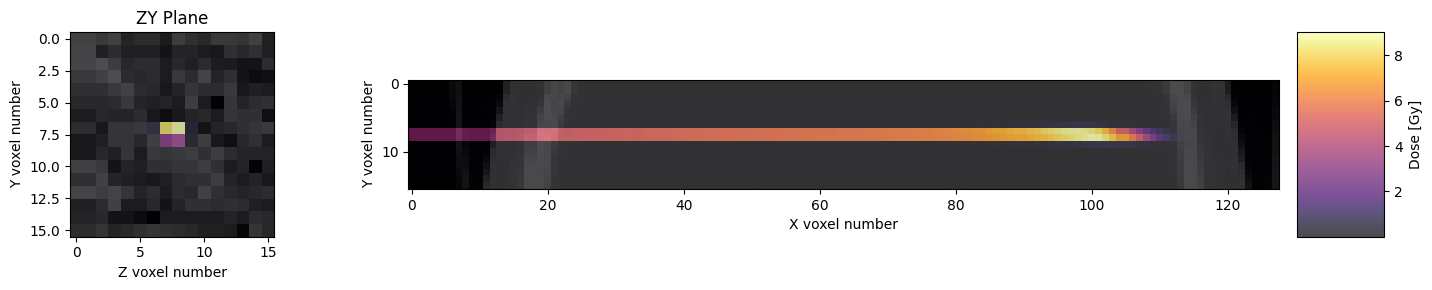

In [6]:
roi_array2 = np.load("/scratch/tappay01/data/data2_resampled/Data2_1500MeV_0Mm_-146.5Mm.npy")
print('array shape', roi_array2.shape)
density2_roi_array = get_density_roi(file_data2)
plot_roi(roi_array2, density2_roi_array)

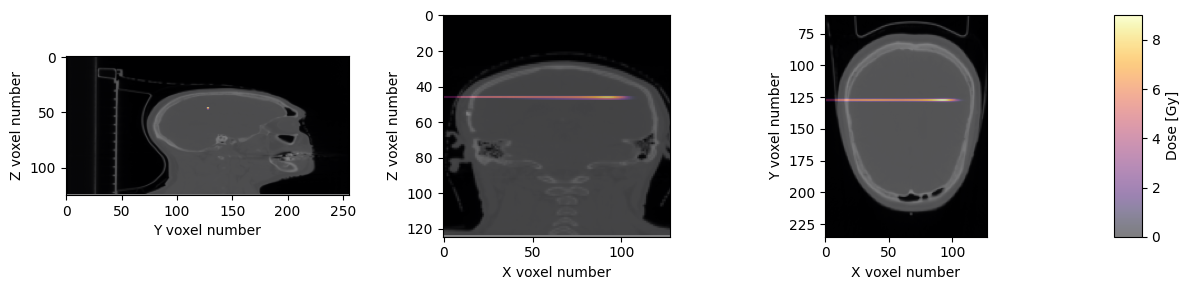

In [7]:
density4_file = "/scratch/tappay01/densities/Data4.npy"
file_data4 ="/scratch/tappay01/data/data4/Data4_1500MeV_0Mm_-71.5Mm.npy"
plot_densities(file_data4, density4_file)

array shape (16, 16, 128)
source index y,z 128 63
start_index [60, 120, 55]
Y direction
voxel number  7


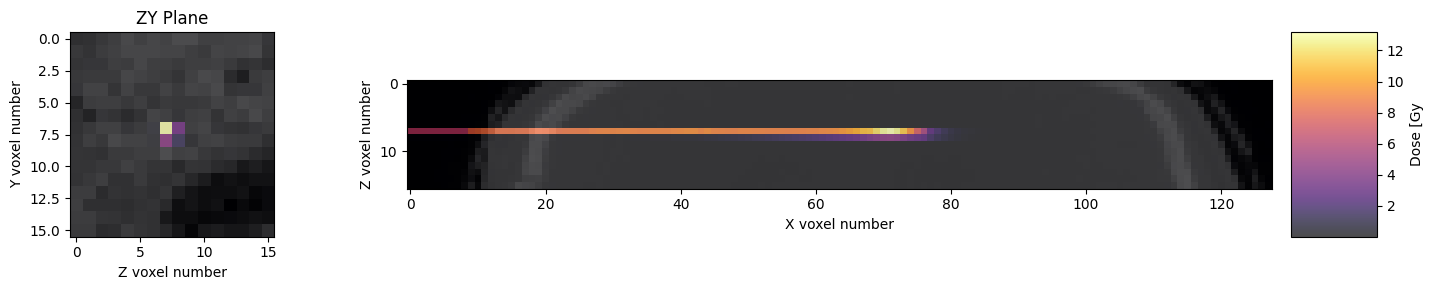

Z direction
voxel number  7


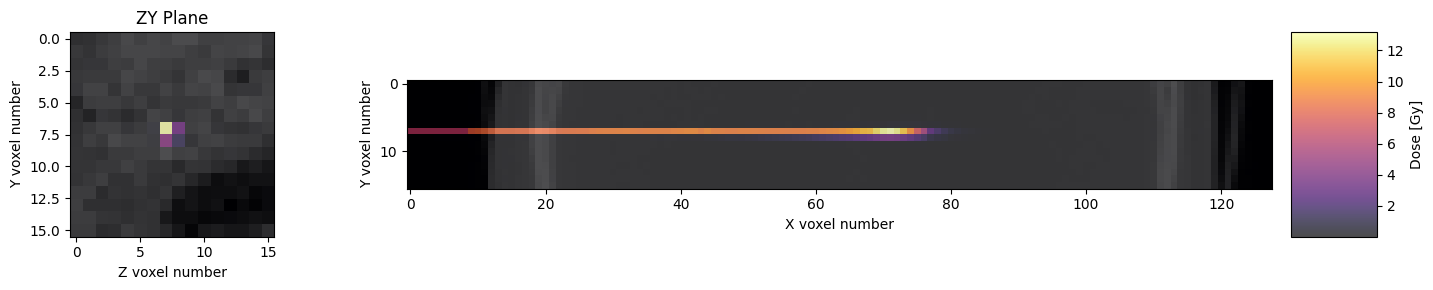

In [8]:
roi_array = np.load("/scratch/tappay01/data/data4_resampled/Data4_2000MeV_25Mm_3.5Mm.npy")
print('array shape', roi_array.shape)
density_roi_array = get_density_roi(file_data4)
plot_roi(roi_array, density_roi_array)

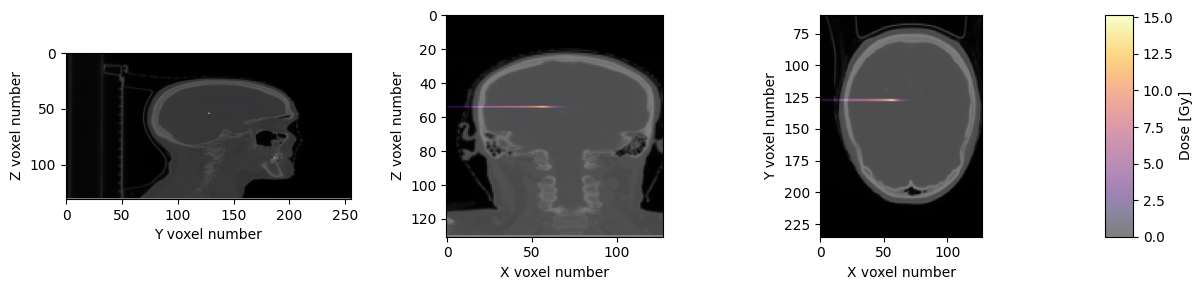

In [9]:
density5_file = "/scratch/tappay01/densities/Data5.npy"
file_data5 = "/scratch/tappay01/data/data5/Data5_1250MeV_0Mm_-71.5Mm.npy"
plot_densities(file_data5, density5_file)

array shape (16, 16, 128)
source index y,z 128 63
start_index [60, 120, 55]
Y direction
voxel number  7


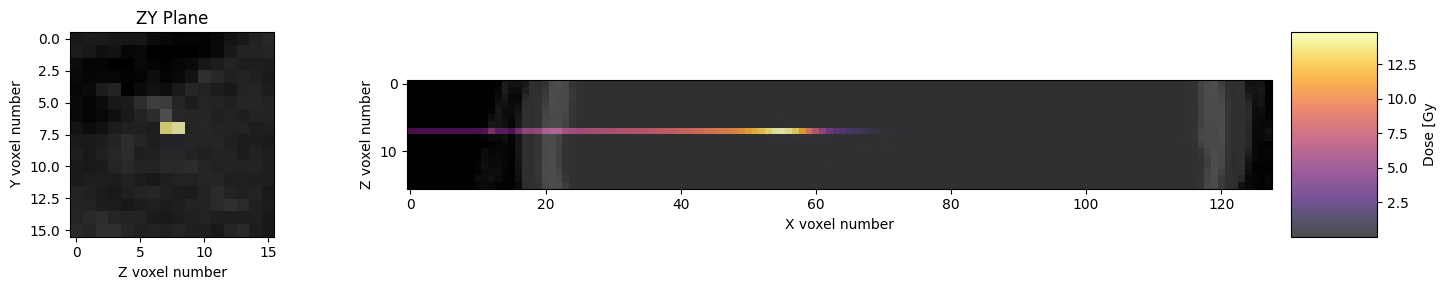

Z direction
voxel number  7


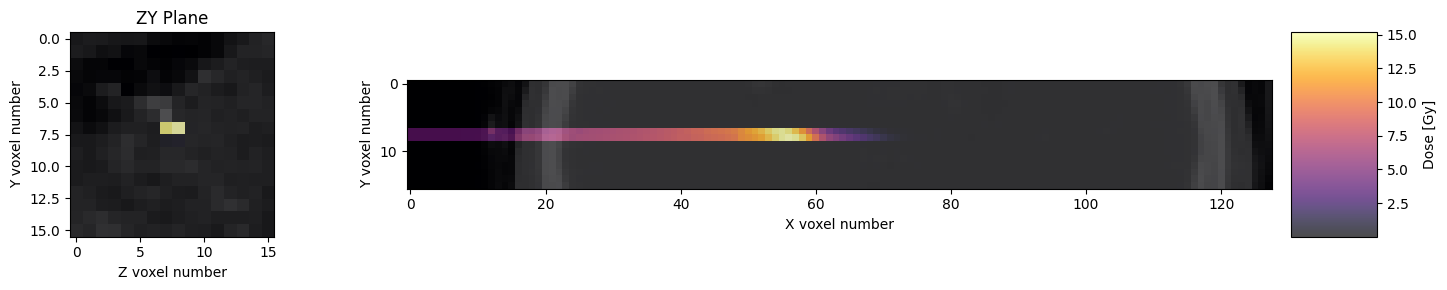

In [10]:
roi_array = np.load("/scratch/tappay01/data/data5_resampled/Data5_1250MeV_0Mm_-71.5Mm.npy")
print('array shape', roi_array.shape)
density_roi_array = get_density_roi(file_data5)
plot_roi(roi_array, density_roi_array)

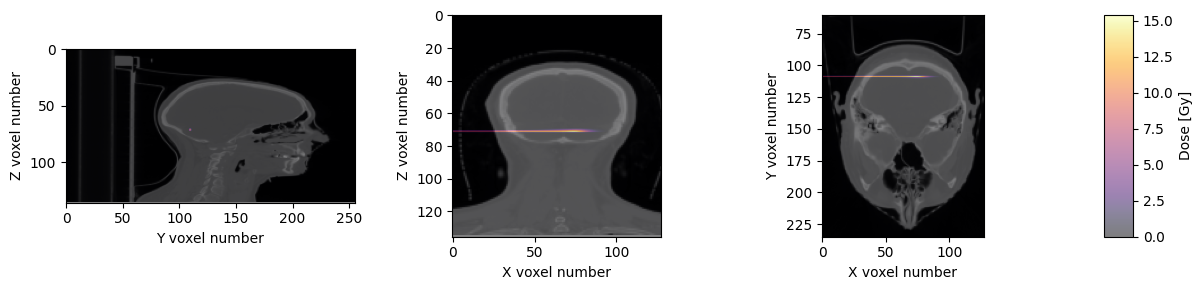

In [11]:
density7_file = "/scratch/tappay01/densities/Data7.npy"
file_data7 = "/scratch/tappay01/data/data7/Data7_1500MeV_-25Mm_-21.5Mm.npy"
plot_densities(file_data7, density7_file)

array shape (16, 16, 128)
source index y,z 110 83
start_index [60, 102, 75]
Y direction
voxel number  7


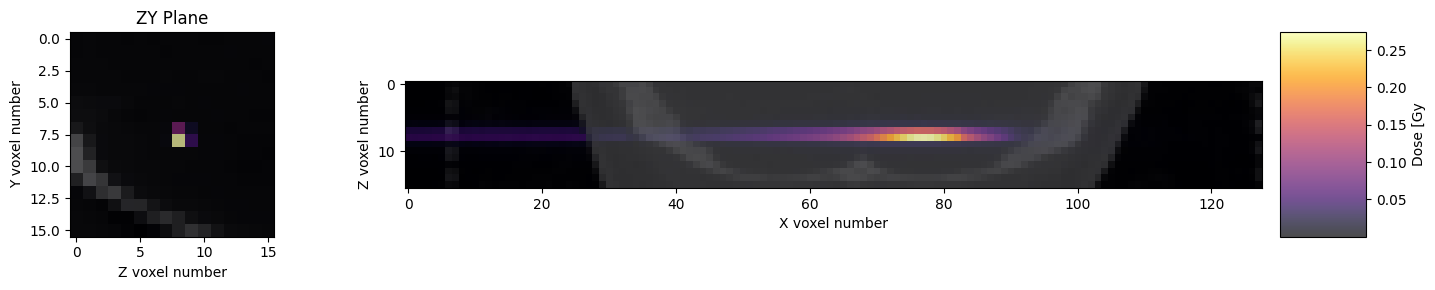

Z direction
voxel number  7


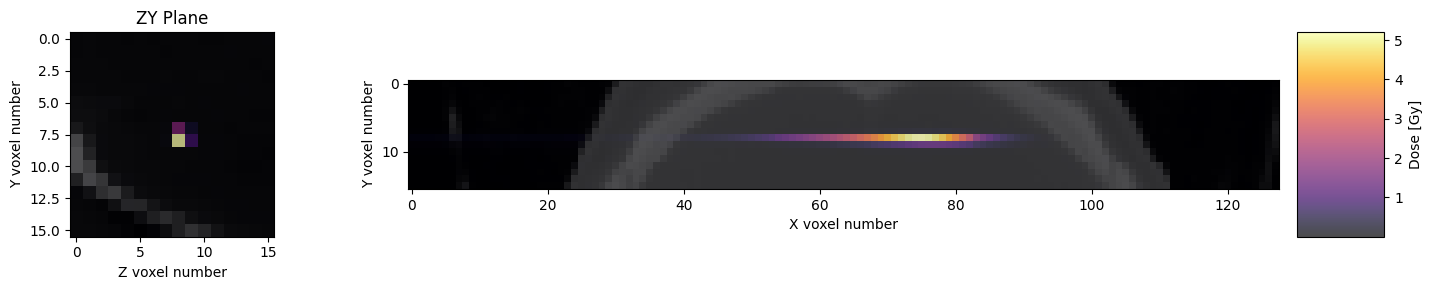

In [12]:
roi_array = np.load("/scratch/tappay01/data/data7_resampled/Data7_1500MeV_-25Mm_-21.5Mm.npy")
print('array shape', roi_array.shape)
density_roi_array = get_density_roi(file_data7)
plot_roi(roi_array, density_roi_array)

Resample all denstities.npy to same voxel size and shape as Data1. Save to new .npy file. Cropping to ROI will be done with CustomDataset. ==> Data4 5 7 are smaller and will get error when resampled to Data1.

The way to do is to crop it to ROI of 16x16x128 just like above for all 30 positions and save them as .npy. CustomDataset will find the corresponding filename.

In [16]:
def create_density_roi(dataset):
    roi_size = (128,16,16) #xyz  
    density_folder =  "/scratch/tappay01/densities/"
    original_density_path = os.path.join(density_folder,  dataset +'.npy')
    resampled = resample_density(original_density_path)
    # Extract ROI    
    # y z source position extract from Dataset notes
    # source at x postion = -110, but use -5 to crop from this point as center, which is index 124. 
    # We want to crop X range size 128 from index 60 to 188 to cover the head.
    for y in datasets[dataset]["positions_y"]:
        for z in datasets[dataset]["positions_z"]:
            source_physical = [-5, y, z] #Mm
            density_roi_array = extract_roi_array(resampled, roi_size, source_physical)
            np.save(os.path.join(density_folder,'{}_{}Mm_{}Mm.npy'.format(dataset, y, z)), density_roi_array)


create_density_roi('Data7')

source index y,z 110 53
start_index [60, 102, 45]
source index y,z 110 63
start_index [60, 102, 55]
source index y,z 110 73
start_index [60, 102, 65]
source index y,z 110 83
start_index [60, 102, 75]
source index y,z 128 53
start_index [60, 120, 45]
source index y,z 128 63
start_index [60, 120, 55]
source index y,z 128 73
start_index [60, 120, 65]
source index y,z 128 83
start_index [60, 120, 75]
source index y,z 146 53
start_index [60, 138, 45]
source index y,z 146 63
start_index [60, 138, 55]
source index y,z 146 73
start_index [60, 138, 65]
source index y,z 146 83
start_index [60, 138, 75]
source index y,z 163 53
start_index [60, 155, 45]
source index y,z 163 63
start_index [60, 155, 55]
source index y,z 163 73
start_index [60, 155, 65]
source index y,z 163 83
start_index [60, 155, 75]
source index y,z 181 53
start_index [60, 173, 45]
source index y,z 181 63
start_index [60, 173, 55]
source index y,z 181 73
start_index [60, 173, 65]
source index y,z 181 83
start_index [60, 173, 75]


Check that we have the same density part as above when loading from file.

array shape (16, 16, 128)
Y direction
voxel number  7


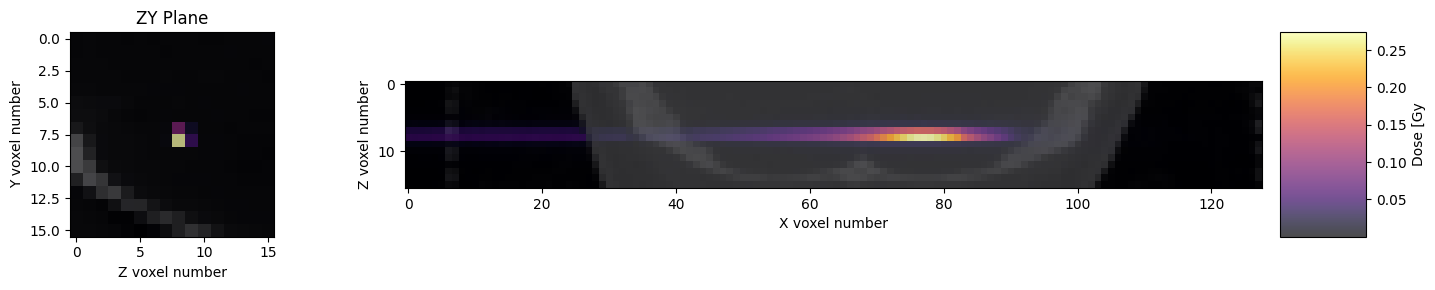

Z direction
voxel number  7


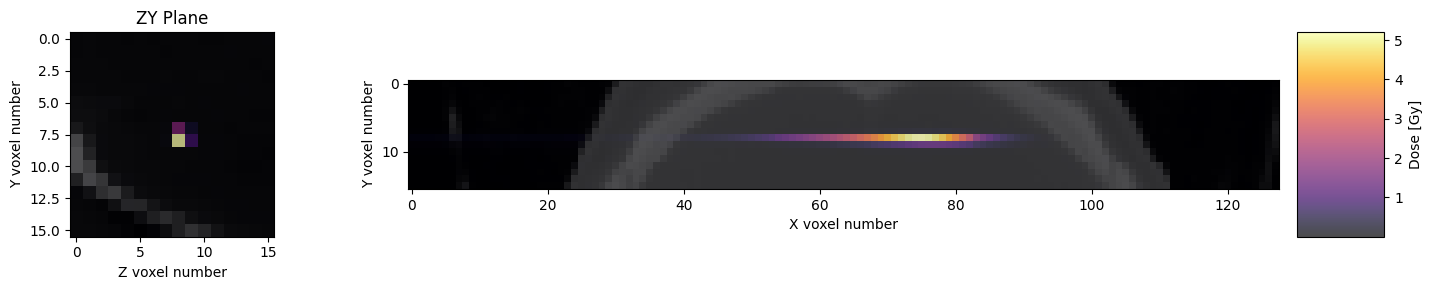

In [17]:
roi_array = np.load("/scratch/tappay01/data/data7_resampled/Data7_1500MeV_-25Mm_-21.5Mm.npy")
print('array shape', roi_array.shape)
density_roi_array_from_file = np.load("/scratch/tappay01/densities/Data7_-25Mm_-21.5Mm.npy")
plot_roi(roi_array, density_roi_array_from_file)